In [42]:
# We will need some functionality 
from typing import List 

# and from math related libraries
import numpy as np
import qutip as qt

import matplotlib.pyplot as plt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator
from qiskit.circuit.library import InnerProduct

In [2]:
def create_zz_hamiltonian(num_qubits: int, connectivity: List[List[int]],
                              h_coeffs: List[float]) -> np.ndarray:
    """Creates a global Hamiltonian consisting of a sum of one (g * Z^i.Z^j) term per device connection.

    Args:
        num_qubits (int): number of qubits of the Hamiltonian
        connectivity (List[List[int]]): connectivity of the device
        h_coeffs (List[float]): list of coefficients of each ZZ term

    Returns:
        np.ndarray: tensored Hamiltonian
    """
    
    dim = 2 ** num_qubits
    num_connections = len(connectivity)
    zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of ZZ operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[c][0]] = qt.sigmaz()
        ops_to_tensor[connectivity[c][1]] = qt.sigmaz()
        zz_hamiltonian += h_coeffs[c] * np.array(qt.tensor(ops_to_tensor))

    return zz_hamiltonian

In [3]:
qubits_count = 4
coeff = 1.
chain_connections = []
interaction_strengths = [coeff for i in range(qubits_count)]
for i in range(qubits_count-1):
    chain_connections.append([i,i + 1])

hamiltonian = create_zz_hamiltonian(qubits_count,chain_connections, interaction_strengths) 
ham_block = HamiltonianGate(data=hamiltonian, time=2) 

In [51]:
def rotate_circ(psi,num_qubits,analog_block):
    qr = QuantumRegister(num_qubits)
    circ = QuantumCircuit(qr)

    circ.r(psi,0.0,0)
    circ.unitary(analog_block, [qr[i] for i in range(num_qubits)], label='analog block')
    circ.measure_all()

    #As always, we can visualize our circuit using the `QuantumCircuit.draw()` method.
    circ.draw()

    simulator = Aer.get_backend('qasm_simulator') 
    job = execute(circ, simulator, shots=1024) 

    result = job.result()
    counts = result.get_counts(circ)
    
    return counts


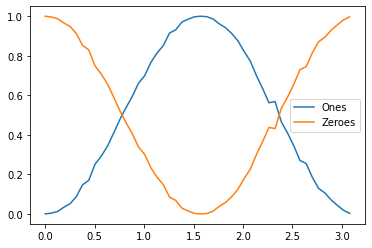

In [52]:
zeroes = []
ones = []
points = 50
angles = [i*np.pi/points for i in range(points)]
for i in range(points):
    angle = angles[i]
    first_rot = rotate_circ(angle*2,qubits_count,ham_block)
    if '0000' in first_rot.keys():
        zeroes.append(first_rot['0000']/1024)
    else:
        zeroes.append(0.)
    if '0001' in first_rot.keys():
        ones.append(first_rot['0001']/1024)
    else:
        ones.append(0.)
    
plt.plot(angles,ones,label="Ones")
plt.plot(angles,zeroes,label="Zeroes")
plt.legend()
#from qiskit.visualization import plot_histogram
#plot_histogram(first_rot)